# German Traffic Sign Benchmark - Hue Histograms

## Overview

### Description of the data
The dataset is about the classification of images of German traffic signs into 43 distinct classes. The classes can be seen in the image below.
The classification is meant to be achieved by using only the global histogram of the hue values in HSV color space, resulting in 256 features per image.

<img src="https://i.imgur.com/AmCEexq.png" title="Traffic sign classes" alt="43 different traffic signs from germany" width="800px">

In [1]:
import math

import joblib
import numpy as np
import matplotlib.pyplot as plt
import openml

from imblearn.pipeline import Pipeline as ILPipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek, SMOTEENN

from sklearn.model_selection import train_test_split, GridSearchCV, ParameterGrid

from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, f1_score, make_scorer, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline

from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

In [2]:
# TODO: DELETE KEY
openml.config.apikey = 'd3aa70dc3cdf0aeac05a5400172fd1e1'

In [3]:
RANDOM_STATE = 42

Loading the data doesn't require any altering of the plain text files.

In [4]:
dataset = openml.datasets.get_dataset(41990)

X, y, categorical_indicator, attribute_names = dataset.get_data(
    dataset_format="array",
    target=dataset.default_target_attribute
    )

classes, class_counts = np.unique(y,return_counts=True)

# # Saving the dataset object structure
# import pprint
# with open('vars-dataset.txt', 'w', encoding='utf8') as f:
#     pprint.pprint(vars(dataset), stream=f)

In [5]:
# OpenML description

print(f'Dataset Name: {dataset.name}')
print(f'OpenML URL: {dataset.url}')
print(f'Original Data URL (link not working): {dataset.original_data_url}')
print(f'Paper URL: {dataset.paper_url}')

print('-'*60)
print(f'Description:\n{dataset.description}')
print('-'*60)

print(f'Licence {dataset.licence}')
print(f'Citation:\n{dataset.citation}')

Dataset Name: GTSRB-HueHist
OpenML URL: https://www.openml.org/data/v1/download/21389569/GTSRB-HueHist.arff
Original Data URL (link not working): http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset
Paper URL: https://www.ini.rub.de/upload/file/1470692848_f03494010c16c36bab9e/StallkampEtAl_GTSRB_IJCNN2011.pdf
------------------------------------------------------------
Description:
The German Traffic Sign Benchmark is a multi-class, single-image classification challenge held at the International Joint Conference on Neural Networks (IJCNN) 2011. We cordially invite researchers from relevant fields to participate: The competition is designed to allow for participation without special domain knowledge.

# Pre-calculated features

To allow scientists without a background in image processing to participate, we several provide pre-calculated feature sets. Each feature set contains the same directory structure as the training image set. For details on the parameters of the feature al

* The sample size is 51839, with each sample comprising of 256 features (in essence they are 255 since the 256th is 1 - sum_of_the_rest).
* The headers are simply `pixel-00000, pixel-00001, ... , pixel-00255`. The rows don't have any special numbering.
* The class labels are in the `class` column and they are namely `0, 1, ... , 42`.
* There are no missing values in the dataset.

In [6]:
print(f'Number of samples: {X.shape[0]}')
print(f'Number of features: {X.shape[1]}')
print(f'Headers: {attribute_names[0]} ... {attribute_names[-1]}')
print(f'Class field: {dataset.default_target_attribute}')
print(f'Classes: {classes[0]} ... {classes[-1]}')
print(f'Number of samples with missing values: {np.sum(np.any(np.isnan(X), axis=1))}')
print(f'Percentage of sample with missing values: {np.mean(np.any(np.isnan(X), axis=1)): .2%}')


Number of samples: 51839
Number of features: 256
Headers: pixel-00000 ... pixel-00255
Class field: class
Classes: 0 ... 42
Number of samples with missing values: 0
Percentage of sample with missing values:  0.00%


In [7]:
# It is indeed a histogram
np.all(X >= 0) and np.all(np.isclose(np.sum(X, axis=1), 1))

True

The dataset is not balanced, since we can see that there are classes which are more than 1.5 times more frequent than some other class (11 times in our worst case).

In [8]:
rarest = np.argmin(class_counts)
most_common = np.argmax(class_counts)

print('The rarest class is {} with frequency {}.'.format(
    classes[rarest], class_counts[rarest]))
print('The most common class is {} with frequency {}.'.format(
    classes[most_common], class_counts[most_common]))
print('The most common class appears {:.1f} times more often than the rarest one.'.format(
    class_counts[most_common] / class_counts[rarest]))

The rarest class is 0 with frequency 270.
The most common class is 2 with frequency 3000.
The most common class appears 11.1 times more often than the rarest one.


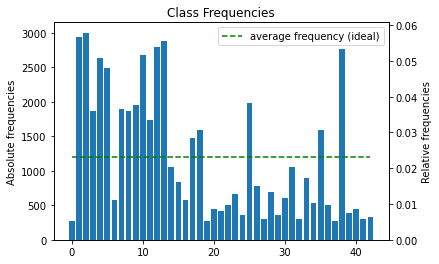

In [9]:
plt.bar(classes, class_counts)
plt.ylabel('Absolute frequencies')
plt.twinx()
plt.bar(classes, class_counts / y.shape[0])
plt.plot((classes[0], classes[-1]),
         (1/len(classes), 1/len(classes)),
        'g--',
        label='average frequency (ideal)')
plt.legend()
plt.ylabel('Relative frequencies')
plt.title('Class Frequencies')
plt.show()

## Preparation

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3, shuffle=True,
    random_state=RANDOM_STATE
)

## Classification

### Out of the box

We can see that the results are quite poor, with the exception of the K Nearest Neighbours classifier, which had a remarkably good accuracy score (and f1 score) of 73%. Those unsatisfying results are to be expected since we haven't tweaked any of the hyperparameters yet. In addition to that, the classes are very imbalanced. We also need to keep in mind that it's harder to correctly classify in 43 different classes instead of, say, 2. For example if a traffic sign has 5 others that look very similar to it, then it's expected to have our sign misclassified as one of those 5.

It is also worth noting that the F1 score of the Dummy classifier is very low. This is because it predicts everything into a single class (the most frequent one: class 2), since the we have by default that `strategy='prior'`.

In [11]:
clf_classes = [
    DummyClassifier,
    GaussianNB,
    KNeighborsClassifier,
    LogisticRegression,
    MLPClassifier,
    SVC
]

In [12]:
@ignore_warnings(category=ConvergenceWarning)
def get_default_measurement(clf_class, X_train, X_test, y_train, y_test):
    clf = clf_class()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    return acc, f1, clf

In [13]:
default_measurements = [get_default_measurement(clf_class, X_train, X_test, y_train, y_test) for clf_class in clf_classes]

In [14]:
# for acc, f1, clf in default_measurements:
#     print(f'| {type(clf).__name__} | {acc:.4f} | {f1: .4f} |')

**Accuracy and F1 score using the default values from sklearn**

|Classifier | Accuracy | F1 score|
| --- | --- | --- |
| DummyClassifier | 0.0592 |  0.0026 |
| GaussianNB | 0.1389 |  0.1168 |
| KNeighborsClassifier | 0.7307 |  0.7394 |
| LogisticRegression | 0.2059 |  0.0729 |
| MLPClassifier | 0.4064 |  0.3739 |
| SVC | 0.4584 |  0.4162 |

In [15]:
def plot_measurements(measurements, title, ax=None):

    accs, f1s, clfs = zip(*measurements)
    clf_names = [type(clf).__name__ for clf in clfs]
    xs = np.arange(len(measurements))
    width = 0.35

    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 8))

    acc_bars = ax.bar(xs - width/2, accs, width, label='Accuracy')
    f1_bars = ax.bar(xs + width/2, f1s, width, label='F1')
    ax.bar_label(acc_bars, fmt='%.3f', padding=3)
    ax.bar_label(f1_bars, fmt='%.3f', padding=3)

    # plt.xlabel('Classifiers')
    ax.set_ylabel('Scores')
    ax.set_title(title)
    ax.set_xticks(xs, clf_names, rotation=30)
    ax.legend()

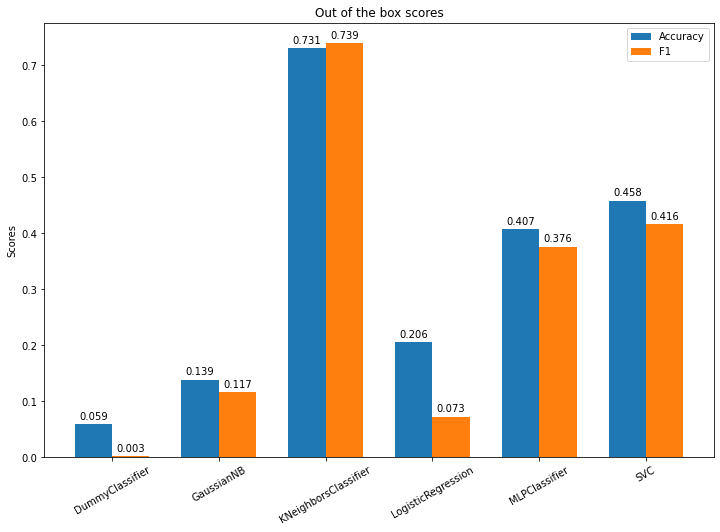

In [16]:
plot_measurements(default_measurements, title='Out of the box scores')
plt.show()

In [17]:
# The Dummy classifier predicts everything as the most frequent class.
np.all(default_measurements[0][2].predict(X_test) == classes[np.argmax(class_counts)])

True

In [18]:
# Confusion matrix for each classifier
def plot_confusion_matrices(measurements, suptitle=None, axs=None):

    # Compute the grid layout
    if axs is None:
        n = len(measurements)
        k = math.isqrt(n)
        q, r = divmod(n - k*k, k)
        nrows = k
        ncols = k + q + (r != 0)  # ceiling division
        fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 10))
    
    # Plot the confusion matrices
    for (_, _, clf), ax in zip(measurements, axs.flat):
        ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test,
                                            colorbar=False, include_values=False, ax=ax)
        ax.set_title(type(clf).__name__)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    # Strip the axes of the unfilled parts of the grid (if there are any)
    for ax in axs.flat[n:]:
        ax.axis('off')

    if suptitle is not None:
        fig.suptitle(suptitle)
        
    fig.tight_layout()

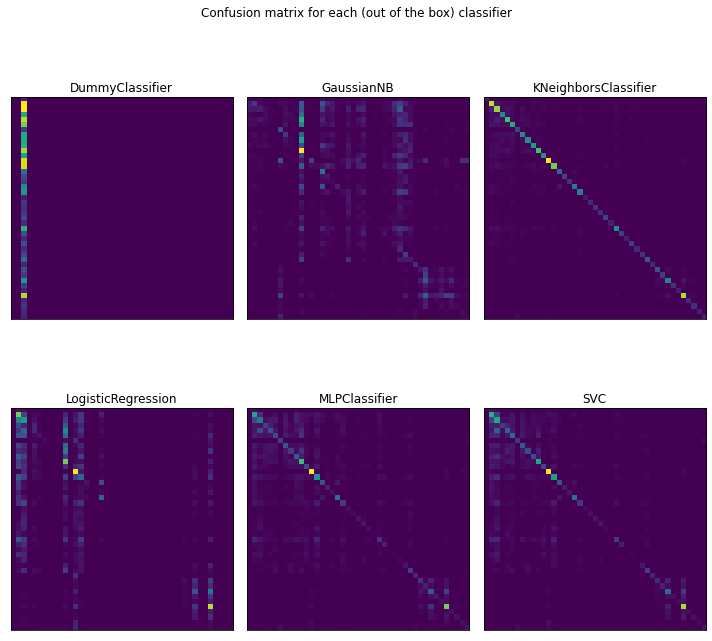

In [19]:
plot_confusion_matrices(default_measurements, suptitle='Confusion matrix for each (out of the box) classifier')
plt.show()

### Optimization

Since our data are probability distributions, applying any preprocessing like centering, scaling, or dimensionality reduction wouldn't make sense. We will use our feautures as they are.
Thus we will focus on balancing our dataset and searching for optimal hyperparameters of our models.

Because our dataset is very imbalanced yet big enough, we will use downsampling to balanced it. This way we will have an easier time training and debugging, while the results will probably be good enough.
We can always switch to oversampling if the results aren't what we expect.

In [20]:
oversample = RandomOverSampler().fit_resample(X_train, y_train)
undersample = RandomUnderSampler().fit_resample(X_train, y_train)
midsample_Tomek = SMOTETomek().fit_resample(X_train, y_train)
midsample_ENN = SMOTEENN().fit_resample(X_train, y_train)

print(
    len(X_train),
    len(oversample[0]),
    len(undersample[0]),
    len(midsample_Tomek[0]),
    len(midsample_ENN[0]),
)

36287 89440 8084 89282 75510


In [21]:
pipes = {}
for clf_class in clf_classes[1:]:
    pipes[clf_class.__name__] = ILPipeline([
        ('balancer', RandomUnderSampler(random_state=RANDOM_STATE)),
        ('clf', clf_class()),
    ])

In [22]:
pipes

{'GaussianNB': Pipeline(steps=[('balancer', RandomUnderSampler(random_state=42)),
                 ('clf', GaussianNB())]),
 'KNeighborsClassifier': Pipeline(steps=[('balancer', RandomUnderSampler(random_state=42)),
                 ('clf', KNeighborsClassifier())]),
 'LogisticRegression': Pipeline(steps=[('balancer', RandomUnderSampler(random_state=42)),
                 ('clf', LogisticRegression())]),
 'MLPClassifier': Pipeline(steps=[('balancer', RandomUnderSampler(random_state=42)),
                 ('clf', MLPClassifier())]),
 'SVC': Pipeline(steps=[('balancer', RandomUnderSampler(random_state=42)),
                 ('clf', SVC())])}

In [23]:
param_grids = {
    'GaussianNB': {
        'clf__priors': [
            # Uniform prior, same as `None` after balancing.
            np.full(len(classes), 1/len(classes)),
            # The prior before balancing.
            np.unique(y_train, return_counts=True)[1] / y_train.shape[0]
        ],
        # This is isn't really a hyperparameter. It's for numerical stability. 
        'clf__var_smoothing': [1e-09]  
    },
    'KNeighborsClassifier': {
        'clf__n_neighbors': [5, 20],
        'clf__weights': ['uniform', 'distance'],
        'clf__p': [1, 2],
        # 'clf__n_jobs': [-1]
    },
    'LogisticRegression': {
        'clf__penalty': ['l2'],
        'clf__C': [0.1, 1., 10.],
        'clf__max_iter': [100],
        # 'clf__n_jobs': [-1],
        'clf__random_state': [RANDOM_STATE]
    },
    'MLPClassifier': {
        'clf__hidden_layer_sizes': [(64,), (32, 64)],
        'clf__activation': ['logistic', 'relu'],
        'clf__alpha': [0.0001, 0.01],
        'clf__learning_rate_init': [0.001, 0.0001],
        'clf__batch_size': [256],
        'clf__max_iter': [200],
        'clf__random_state': [RANDOM_STATE]
    },
    'SVC': {
        'clf__C': [0.1, 1., 10.],
        'clf__kernel': ['linear', 'rbf'],
        'clf__max_iter': [200],
        'clf__random_state': [RANDOM_STATE]
    }
}

n_models = 2 * sum(1 for param_grid in param_grids.values()
                            for _ in ParameterGrid(param_grid))
print(f'{n_models} models will be cross validated')

70 models will be cross validated


In [24]:
# def cv_train(scoring):
#     cv_clfs = {}
#     for name, pipe in pipes.items():
#         estimator = GridSearchCV(
#             pipe, param_grids[name], cv=10,
#             scoring=scoring,
#             error_score='raise',
#             verbose=2, n_jobs=-1
#         )
#         estimator.fit(X_train, y_train)
#         cv_clfs[name] = estimator
#     return cv_clfs

In [25]:
# cv_clfs_acc = cv_train(scoring='accuracy')

In [26]:
# cv_clfs_f1 = cv_train(scoring='f1_macro')